In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Import Packages

In [2]:
%cd ..

/home/henry/Pictures/BigData_ABSA


In [3]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import src

In [5]:
from src.utils import *

## 2. Prepare Data

### 2.1 Load Data

In [6]:
df_train = pd.read_csv('data/processed_train.csv')
df_valid = pd.read_csv('data/processed_valid.csv')
df_test = pd.read_csv('data/processed_test.csv')

In [7]:
df_train.tail(5)

,tokenize,SCREEN#Positive,SCREEN#Neutral,SCREEN#Negative,CAMERA#Positive,CAMERA#Neutral,CAMERA#Negative,FEATURES#Positive,FEATURES#Neutral,FEATURES#Negative,...,DESIGN#Negative,PRICE#Positive,PRICE#Neutral,PRICE#Negative,GENERAL#Positive,GENERAL#Neutral,GENERAL#Negative,SER&ACC#Positive,SER&ACC#Neutral,SER&ACC#Negative
7781,8g cái đi đánh là mạng giật giật ko chịu nổi c...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7782,mua dk giảm 500k mà lỗi lòi ra hết treo màn_hì...,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7783,máy sài 3 tháng rồi rất ok pin trâu khỏi nói s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7784,rất tiếc hàng realme ko có ốp lưng ngoài nên k...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
7785,mình rất thất_vọng khi mua máy này bắt wifi cự...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


### 2.2 Select Max Length

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7786/7786 [00:01<00:00, 5352.80it/s]
/home/henry/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


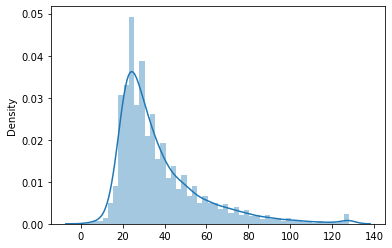

In [9]:
DisplayTokenLen(df_train, tokenizer)

### 2.3. Check Data

In [10]:
# Test the tokenizer
test_text = "máy sài 3 tháng rồi rất ok pin trâu khỏi nói sài cả ngày đến tối 12 giờ đêm mới sạc mình chơi game liên_quân cả ngày rất ok"
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 128,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[    0,   558,  1302,  9412,   107,    78,   182,    59, 11685,  2179,
          2959,   353,    96,  1302,  9412,    94,    43,    30,   878,   445,
           232,   396,    60,  3941,    68,   379,  1724,  7660,    94,    43,
            59, 11685,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

### 2.3 Transform for Pytorch Model

In [11]:
from src.model import CustomDataset

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
target_list = GetNewLabels()
MAX_LEN = conf.MAX_LEN
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [13]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([    0,    60,   188,   558,    23,    35, 44553,  3385,  3385,  2662,
         33640,   841, 11685,  5967,  2959,   690,   284,   258,  3998,   523,
           889,   537,  2303,  3961,  3455,  1575,   726,  4097,   164,    15,
         11535,   650,  1408,  3857,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [14]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=conf.TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=conf.VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=conf.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## 3. Model Setting

In [15]:
from src.model import BERTClass

model = BERTClass()
# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False
model.to(conf.device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [16]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/home/henry/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. Training

In [17]:
from src.utils import SupportModel

In [18]:
SupportModel = SupportModel()

In [19]:
history = defaultdict(list)
best_accuracy = 0
EPOCHS = conf.EPOCHS
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = SupportModel.train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = SupportModel.eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/244 [00:00<?, ?it/s]

KeyboardInterrupt: 

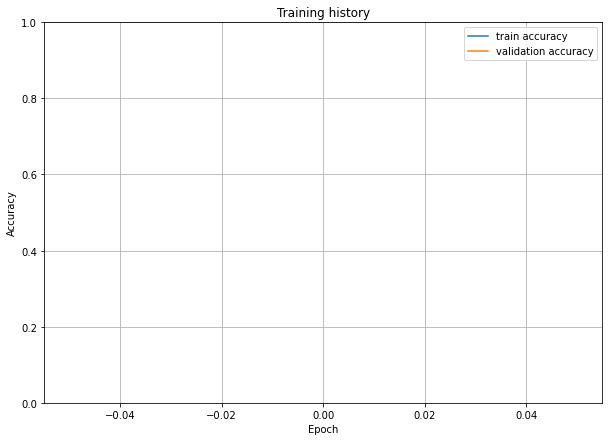

In [20]:
PlotTrainingHistory(history)

## 5. Evaluate

In [ ]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
model = model.to(device)

In [ ]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

In [ ]:
comments, predictions, prediction_probs, target_values = SupportModel.get_predictions(model, test_data_loader)

In [ ]:
print(f"comments:{len(comments)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

In [ ]:
# Generate Classification Metrics
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

## 6. Predict Raw Input

In [ ]:
SupportModel.predict_raw_text(model, tokenizer, raw_text='')